C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+25002=25002. 
  total_n_samples))


Compiling model...
'compile' took 0.000131 s



C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3002=3002. 
  total_n_samples))


Training model...

Step      Train loss              Test loss               Test metric
0         [3.80e+01, 1.09e-08]    [3.80e+01, 1.09e-08]    []  
1000      [9.13e+00, 7.83e-05]    [9.13e+00, 7.83e-05]    []  
2000      [9.13e+00, 7.83e-05]    [9.13e+00, 7.83e-05]    []  
3000      [9.13e+00, 7.83e-05]    [9.13e+00, 7.83e-05]    []  
4000      [9.13e+00, 7.83e-05]    [9.13e+00, 7.83e-05]    []  
5000      [9.13e+00, 7.83e-05]    [9.13e+00, 7.83e-05]    []  
6000      [9.09e+00, 7.83e-05]    [9.09e+00, 7.83e-05]    []  
7000      [5.40e+00, 7.75e-05]    [5.40e+00, 7.75e-05]    []  
8000      [1.48e+00, 8.04e-05]    [1.48e+00, 8.04e-05]    []  
9000      [1.05e+00, 8.07e-05]    [1.05e+00, 8.07e-05]    []  
10000     [9.45e-01, 7.87e-05]    [9.45e-01, 7.87e-05]    []  
11000     [9.16e-01, 7.80e-05]    [9.16e-01, 7.80e-05]    []  
12000     [8.91e-01, 7.81e-05]    [8.91e-01, 7.81e-05]    []  
13000     [4.64e-01, 9.97e-05]    [4.64e-01, 9.97e-05]    []  
14000     [1.08e-01, 1.30e-04

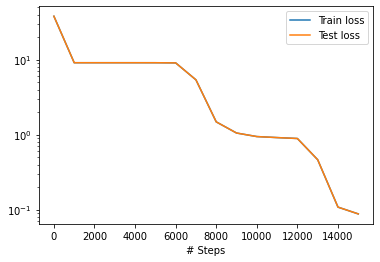

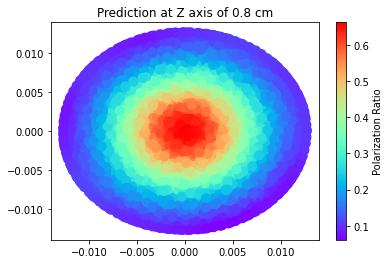

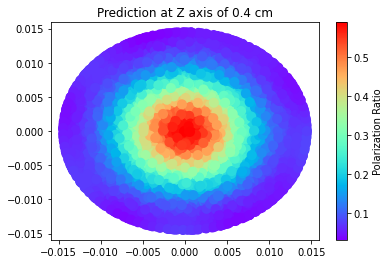

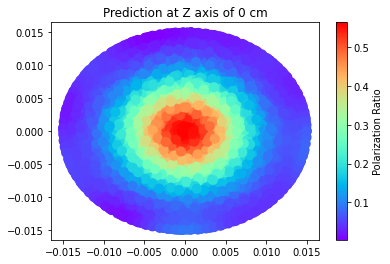

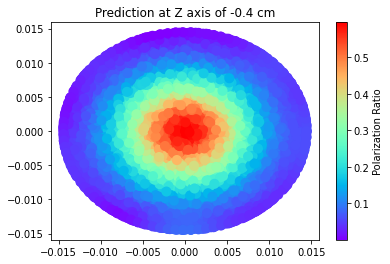

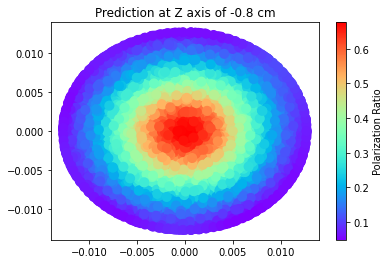

In [14]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 21 20:38:19 2022
高斯光束的情况，Rop = Ropz * exp(x,y)
Rop调高点，好看。40有点不够，在COMSOL中也确认下。

决定用torch作为backend，tensorflow搞了两天，解决不了转numpy的问题。因为tf1.0版本，session的创建在函数内部，不好传递出来。不如直接整torch
Rop 不均匀，发生衰减的情形。
本文件仿真有泵浦光补偿的情况

@author: Administrator
"""

"""Backend supported: tensorflow.compat.v1, torch"""
import deepxde as dde
import numpy as np
#from deepxde.backend import tf
#from deepxde.backend import torch
import torch
from scipy.special import gamma
from scipy.special import lambertw

#import mayavi.mlab as mlab
import matplotlib.pyplot as plt

from draw_counter import random_sphere_points, uniform_sample_points
from PIL import Image

torch.set_default_tensor_type(torch.cuda.FloatTensor)

## define parameters
D = 0.58 * 1e-4 ## 扩散系数，cm2/s
#Rop0 = 60
#Rrel = 17.5573
Rsd = 17.5573
Rwall = 2.56401 
rpump = 0.75 * 1e-2
q = 5 ## 减速因子
rcell = 1.5 * 1e-2

Rrel = Rsd+q*Rwall

## 抽运光衰减+补偿，实验
# 面积和长度，统一成厘米
## 单位统一，还是有问题，尝试到米（m）？
I = 25 * 1e-3 # 光强W
T = 170
k1 = 10**(-20)
k2 = 10**(-17)
k3 = 1e6
sigm = 2.34601 * 1e-17 ## 平方厘米

n = k3*(1/(T+273.15))*10**(21.866+4.402-4453/(T+273.15))


# def fpde(x, y, int_mat):
#     """\int_theta D_theta^alpha u(x)"""
#     if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
#         int_mat = tf.SparseTensor(*int_mat)
#         lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
#     else:
#         lhs = tf.matmul(int_mat, y)
#     lhs = lhs[:, 0]
#     lhs *= gamma((1 - alpha) / 2) * gamma((3 + alpha) / 2) / (2 * np.pi ** 2)
#     x = x[: tf.size(lhs)]
#     rhs = (
#         2 ** alpha
#         * gamma(2 + alpha / 2)
#         * gamma((3 + alpha) / 2)
#         / gamma(3 / 2)
#         * (1 - (1 + alpha / 3) * tf.reduce_sum(x ** 2, axis=1))
#     )
#     return lhs - rhs

def bloch_pde(x_in, y_in):
    ''' x_in: (x,y,z) axis
        y_in: Pz polarization
    '''
    x_in_copy = x_in.detach().cpu().numpy()
    x = x_in_copy[:, 0:1]
    y = x_in_copy[:, 1:2]
    z = x_in_copy[:, 2:3]
    
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
#     x_arr = x.eval(session=sess)
    dy_xx = dde.grad.hessian(y_in, x_in, i=0, j=0)
    dy_yy = dde.grad.hessian(y_in, x_in, i=1, j=1)
    dy_zz = dde.grad.hessian(y_in, x_in, i=2, j=2) # dy/dxidxj
    
    plog1 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))-n*sigm*z))
    plog2 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))+n*sigm*z))
    Rop0_z = k2*(Rrel/sigm)*(np.real(plog1) + np.real(plog2))
    Rop0_z = np.asarray(Rop0_z)    
    
    Rop = Rop0_z * np.exp(-2*(x**2+y**2)/rpump**2)
    Rop = torch.from_numpy(Rop).cuda()
    #Rop = Rop0
    
    return -D*(dy_xx+dy_yy+dy_zz) + ((Rop+Rsd)/q+Rwall)*y_in - Rop/q

# def func(x):
#     return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2)) ** (
#         1 + alpha / 2
#     )

def func_boundary(x_in, Pz, numpy_X):
    x_in_copy = x_in.detach().cpu().numpy()
    x = x_in_copy[:, 0:1]
    y = x_in_copy[:, 1:2]
    z = x_in_copy[:, 2:3]
    
    dPz_x = dde.grad.jacobian(Pz, x_in, i=0, j=0) # This is right
    dPz_y = dde.grad.jacobian(Pz, x_in, i=0, j=1)
    dPz_z = dde.grad.jacobian(Pz, x_in, i=0, j=2)
    
    #Rop = Rop0 * np.exp(-2*(x**2+y**2)/rpump**2)
    
    plog1 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))-n*sigm*z))
    plog2 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))+n*sigm*z))
    Rop0_z = k2*(Rrel/sigm)*(np.real(plog1) + np.real(plog2))
    Rop0_z = np.asarray(Rop0_z)      
    
    Rop = Rop0_z * np.exp(-2*(x**2+y**2)/rpump**2)
    
    second_term = np.sqrt(1/2*np.abs(Rop*D))
    
    # tranfer back to torch.tensor
    second_term = torch.from_numpy(second_term).cuda()
    Rop = torch.from_numpy(Rop).cuda()
    x = torch.from_numpy(x).cuda()
    y = torch.from_numpy(y).cuda()
    z = torch.from_numpy(z).cuda()
    
    return 1e3*(D/rcell*(x*dPz_x + y*dPz_y + z*dPz_z) + Pz*second_term)
## 好像边界条件没约束上，加个比例系数试试，1e3

geom = dde.geometry.Sphere([0, 0, 0], rcell)
#bc = dde.icbc.DirichletBC(geom, func_boundary, lambda _, on_boundary: on_boundary)

#bc = dde.icbc.RobinBC(geom, func_boundary, lambda _, on_boundary: on_boundary)
bc = dde.icbc.OperatorBC(geom, func_boundary, lambda _, on_boundary: on_boundary) # 函数调研下，operatorBC

# data = dde.data.FPDE(
#     geom,
#     fpde,
#     alpha,
#     bc,
#     [8, 8, 100],
#     num_domain=256,
#     num_boundary=1,
#     solution=func,
# )

data = dde.data.PDE(geom, bloch_pde, bc, num_domain=25000, num_boundary=3000)

net = dde.nn.FNN([3] + [30] * 4 + [1], "tanh", "Glorot normal")
# net.apply_output_transform(
#     lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
# )

model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
#losshistory, train_state = model.train(epochs=8000, model_save_path='Bloch_Rop_v1')
losshistory, train_state = model.train(epochs=15000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


#z_axis_list = [1.2, 0.8, 0.4, -0.4, -0.8, -1.2]
z_axis_list = [0.8, 0.4, 0, -0.4, -0.8]
for z_axis in z_axis_list:
    figure = plt.figure() 
    X = random_sphere_points(z= z_axis*1e-2, rcell=rcell)
    y_pred = model.predict(X)[:, 0]
    np.save('./result/axes_{}'.format(z_axis), X)
    np.save('./result/pred_{}'.format(z_axis), y_pred)
    
    x_axis, y_axis = X[:, 0], X[:, 1]
    plt.scatter(x_axis, y_axis, s=50, c= y_pred, cmap='rainbow', linewidth=3)
    plt.colorbar(label="Polarization Ratio") 
#     plt.xlim(-1.5, 1.5)
#     plt.ylim(-1.5, 1.5)
    plt.title('Prediction at Z axis of {0} cm'.format(z_axis))

[2.55625271e-05+0.j 2.79070214e-05+0.j 3.04665368e-05+0.j
 3.32607925e-05+0.j 3.63113156e-05+0.j 3.96416072e-05+0.j
 4.32773233e-05+0.j 4.72464720e-05+0.j 5.15796296e-05+0.j
 5.63101755e-05+0.j]
50.00000000000002 170.57623987019113


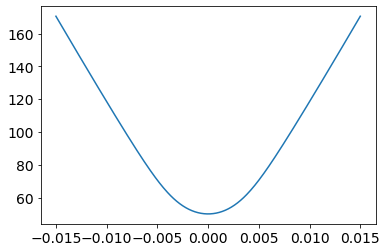

In [6]:
import deepxde as dde
import numpy as np
#from deepxde.backend import tf
#from deepxde.backend import torch
import torch
from scipy.special import gamma
from scipy.special import lambertw

#import mayavi.mlab as mlab
import matplotlib.pyplot as plt

from matplotlib.pyplot import MultipleLocator
#从pyplot导入MultipleLocator类，这个类用于设置刻度间隔

from draw_counter import random_sphere_points, uniform_sample_points
from PIL import Image

torch.set_default_tensor_type(torch.cuda.FloatTensor)

## define parameters
D = 0.58 * 1e-4 ## 扩散系数，cm2/s
#Rop0 = 60
#Rrel = 17.5573
Rsd = 17.5573
Rwall = 2.56401 
rpump = 0.75 * 1e-2
q = 5 ## 减速因子
rcell = 1.5 * 1e-2

Rrel = Rsd+q*Rwall

## 抽运光衰减+补偿，实验
# 面积和长度，统一成厘米
## 单位统一，还是有问题，尝试到米（m）？
I = 25 * 10**(-3) # 光强W
T = 170
k1 = 10**(-20)
k2 = 10**(-17)
k3 = 1e6
sigm = 2.34601 * 10**(-17) ## 平方厘米

n = k3*(1/(T+273.15))*10**(21.866+4.402-4453/(T+273.15))

z = np.linspace(-rcell, rcell, 301)
plog1 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))-n*sigm*z))
plog2 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))+n*sigm*z))

Rop0_z = k2*(Rrel/sigm)*(np.real(plog1) + np.real(plog2))
Rop0_z = np.asarray(Rop0_z)
print(plog2[:10])
plt.plot(z, np.real(Rop0_z))
plt.tick_params(axis='both',which='major',labelsize=14)

#y_major_locator=MultipleLocator(10)
#ax.yaxis.set_major_locator(y_major_locator)
#把y轴的刻度间隔设置为10，并存在变量里
print(Rop0_z.min(), Rop0_z.max())

[3.78004984e-08+0.j 4.12675077e-08+0.j 4.50525063e-08+0.j
 4.91846597e-08+0.j 5.36958084e-08+0.j 5.86207134e-08+0.j
 6.39973239e-08+0.j 6.98670695e-08+0.j 7.62751800e-08+0.j
 8.32710334e-08+0.j]
Rrel  30.37735


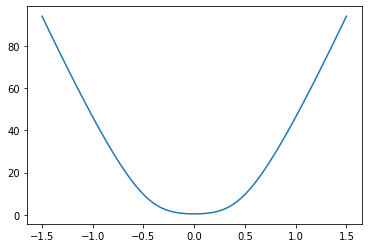

In [20]:
## 绘制Rop0沿z轴的分布，与COMSOL比较，确定lambertw函数是否正常
import deepxde as dde
import numpy as np
#from deepxde.backend import tf
#from deepxde.backend import torch
import torch
from scipy.special import gamma
from scipy.special import lambertw

#import mayavi.mlab as mlab
import matplotlib.pyplot as plt

from draw_counter import random_sphere_points, uniform_sample_points
from PIL import Image

torch.set_default_tensor_type(torch.cuda.FloatTensor)

## define parameters
D = 0.58  ## 扩散系数，cm2/s
#Rop0 = 60
#Rrel = 17.5573
Rsd = 17.5573
Rwall = 2.56401 
rpump = 0.75 
q = 5 ## 减速因子
rcell = 1.5 

Rrel = Rsd+q*Rwall

## 抽运光衰减+补偿，实验
# 面积和长度，统一成厘米
## 单位统一到cm，观察Rop_z
I = 25 *1e-1   # 光强W
T = 170
k1 = 10**(-12)
k2 = 10**(-13)
k3 = 1
sigm = 2.34601 * 10**(-13) ## 平方厘米

n = k3*(1/(T+273.15))*10**(21.866+4.402-4453/(T+273.15))

z = np.linspace(-rcell, rcell, 301)
plog1 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))-n*sigm*z))
plog2 = lambertw((sigm*I/(Rrel*k1))*np.exp((sigm*I/(Rrel*k1))+n*sigm*z))

Rop0_z = k2*(Rrel/sigm)*(np.real(plog1) + np.real(plog2))
Rop0_z = np.asarray(Rop0_z)
print(plog2[:10])
print('Rrel ', Rrel)
plt.plot(z, np.real(Rop0_z))

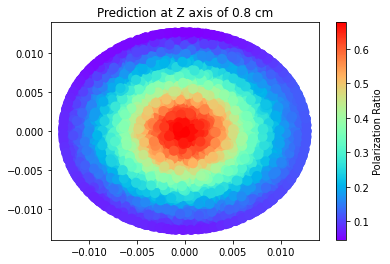

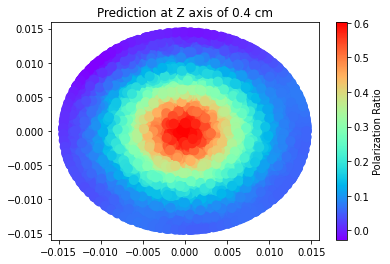

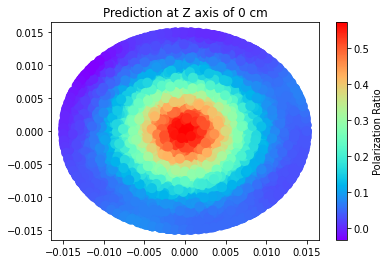

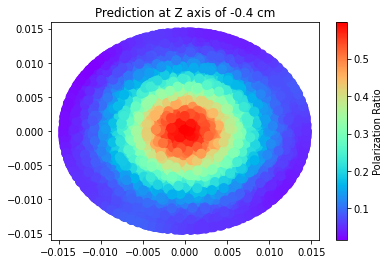

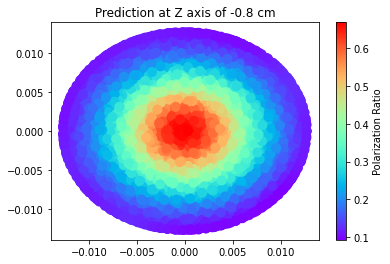

In [7]:
# z_axis_list = [0.8, 0.4, 0, -0.4, -0.8]
# for z_axis in z_axis_list:
#     figure = plt.figure() 
#     X = random_sphere_points(z= z_axis*1e-2, rcell=rcell)
#     y_pred = model.predict(X)[:, 0]
#     np.save('./result/axes_{}'.format(z_axis), X)
#     np.save('./result/pred_{}'.format(z_axis), y_pred)
    
#     x_axis, y_axis = X[:, 0], X[:, 1]
#     plt.scatter(x_axis, y_axis, s=50, c= y_pred, cmap='rainbow', linewidth=3)
#     plt.colorbar(label="Polarization Ratio") 
# #     plt.xlim(-1.5, 1.5)
# #     plt.ylim(-1.5, 1.5)
#     plt.title('Prediction at Z axis of {0} cm'.format(z_axis))

In [ ]:
# x_1 = tf.ones((10, 1))
# sess = tf.compat.v1.Session()
# with sess.as_default():
#     x_1.eval()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random


#rcell = 1.5
sample_num = 200

def polar_sphere_points(z, sample_num = 200):
    radius_z = np.sqrt(rcell**2 - z**2)
    sample_data = []    
    
    for theta in np.linspace(0, 2*np.pi, sample_num):
        for r in np.linspace(0, radius_z, sample_num):
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            sample_data.append((x, y, z)) # 200*200 = 40000个采样点
        
    sample_data = np.asarray(sample_data, dtype=np.float32
                            )
    return sample_data

def polar_sphere_YZ(x, sample_num = 200):
    radius_x = np.sqrt(rcell**2 -x**2)
    sample_data = []    
    
    for theta in np.linspace(0, 2*np.pi, sample_num):
        for r in np.linspace(0, radius_x, sample_num):
            y = r * np.cos(theta)
            z = r * np.sin(theta)
            sample_data.append((x, y, z)) # 200*200 = 40000个采样点
        
    sample_data = np.asarray(sample_data, dtype=np.float32
                            )
    return sample_data

def YZ_Y0(sample_num=301, rcell=1.5*1e-2):
    x = 0
    y = 0
    z_sequence = np.linspace(-rcell, rcell, sample_num)
    sample_data = []
    
    for z in z_sequence:
        sample_data.append((x, y, z))
        
    sample_data = np.asarray(sample_data, dtype=np.float32)
    return sample_data


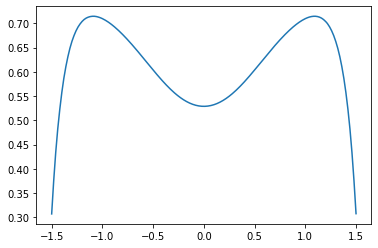

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 28 16:45:06 2022

@author: Administrator
绘制COMSOL YZ平面的Y=0处的结果。
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cmath

file_idx = '0.4'
filename = './result/z_axis.csv'.format(file_idx)
#df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
df = pd.read_csv(filename, header=12, names=['Pz'])
## (x, y, z) u1, 20796*4

# x = np.asarray(df['x'])
# y = np.asarray(df['y'])
# z = np.asarray(df['z'])
Pz_COMSOL = np.asarray(df['Pz'])
#Pz
#len(Pz) cm, 注意单位换算，统一m
z_sequence = np.linspace(-1.5, 1.5, 301)

plt.plot(z_sequence, Pz_COMSOL)
## 细网格？还是要转成极坐标的，在极坐标系下，把一维转成二维，再排序插值。

## 转xy坐标，为角度、半径坐标（极坐标），函数
## 

# def xy_to_polar(x, y, Pz):
#     r_xy = []
#     theta_xy = []
#     for i in range(len(x)):
#         cn = complex(x[i], y[i])
#         r_i, theta_i = cmath.polar(cn)
#         r_xy.append(r_i)
#         theta_xy.append(theta_i)
#     r_xy = np.asarray(r_xy)    
#     theta_xy = np.asarray(theta_xy)
    
#     return (r_xy, theta_xy, Pz)
    
# r, theta, Pz = xy_to_polar(x, y, Pz)
# r_max = r.max()

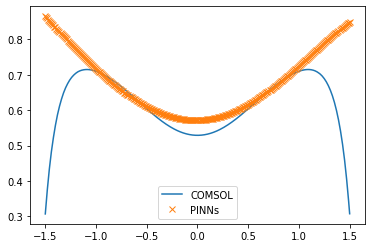

In [13]:
## 绘制YZ平面，
##先使用已有的固定z坐标采样，然后，对采样平面转置，使X = 0
from matplotlib.colors import Normalize
vmin = 0
vmax = 0.8
norm = Normalize(vmin = vmin,vmax = vmax)


XY_00 = YZ_Y0() 
#X_transpose = np.transpose(X_origin, [2, 0, 1])
y_pred_z_axis = model.predict(XY_00)[:, 0]


plt.plot(z_sequence, Pz_COMSOL, label='COMSOL')
plt.plot(z_sequence, y_pred_z_axis, marker='x',linestyle='',label='PINNs')
plt.legend()

In [ ]:
## 绘制YZ平面，

##先使用已有的固定z坐标采样，然后，对采样平面转置，使X = 0
from matplotlib.colors import Normalize
vmin = 0
vmax = 0.8
norm = Normalize(vmin = vmin,vmax = vmax)


X_origin = polar_sphere_YZ(0) 
print(X_origin)
#X_transpose = np.transpose(X_origin, [2, 0, 1])
y_pred_YZ = model.predict(X_origin)[:, 0]
y_pred_YZ = np.reshape(y_pred_YZ, (sample_num, sample_num))

theta_sequence = np.linspace(0, 2*np.pi, sample_num)
r_sequence = np.linspace(0, 1.5, sample_num)

ax = plt.subplot(111,projection='polar')
ax.pcolor(theta_sequence, r_sequence, y_pred_YZ.T, shading='auto', cmap='rainbow')
ax.set_rgrids([])

# cb = ax.colorbar()
# cb.set_ticks([0.1*(i+1) for i in range(8)])
# cb.ax.tick_params(labelsize=12)  #设置色标刻度字体大小。

plt.show()

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  7.53768836e-05  0.00000000e+00]
 [ 0.00000000e+00  1.50753767e-04  0.00000000e+00]
 ...
 [ 0.00000000e+00  1.48492465e-02 -3.63701637e-18]
 [ 0.00000000e+00  1.49246231e-02 -3.65547822e-18]
 [ 0.00000000e+00  1.49999997e-02 -3.67394048e-18]]


C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


NameError: name 'fig' is not defined

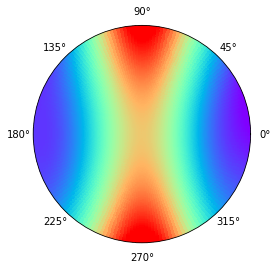

In [6]:
## 绘制YZ平面，

##先使用已有的固定z坐标采样，然后，对采样平面转置，使X = 0
from matplotlib.colors import Normalize
vmin = 0
vmax = 0.8
norm = Normalize(vmin = vmin,vmax = vmax)


X_origin = polar_sphere_YZ(0) 
print(X_origin)
#X_transpose = np.transpose(X_origin, [2, 0, 1])
y_pred_YZ = model.predict(X_origin)[:, 0]
y_pred_YZ = np.reshape(y_pred_YZ, (sample_num, sample_num))

theta_sequence = np.linspace(0, 2*np.pi, sample_num)
r_sequence = np.linspace(0, 1.5, sample_num)

ax = plt.subplot(111,projection='polar')
ax.pcolor(theta_sequence, r_sequence, y_pred_YZ.T, shading='auto', cmap='rainbow', norm=norm)
ax.set_rgrids([])

cb = fig.colorbar(fig5, ax=[ax], shrink=0.7)
#cb.set_ticks([0.1*(i+1) for i in range(8)])
cb.ax.tick_params(labelsize=12)  #设置色标刻度字体大小。

plt.show()

In [ ]:
X_origin.shape

In [ ]:
#x, y = X_data[:, 0], X_data[:, 1]
sample_num = 200
#z = 0.4
z_axis_list = [0.8, 0.4, 0, -0.4, -0.8]
y_pred_list = []
for z in z_axis_list:
    radius_z = np.sqrt(rcell**2 - z**2)
    X = polar_sphere_points(z)
    x = X[:, 0]
    y_pred = model.predict(X)[:, 0]
    y_pred_matrix = np.reshape(y_pred, (sample_num, sample_num))
    y_pred_list.append(y_pred_matrix)


theta_sequence = np.linspace(0, 2*np.pi, sample_num)
r_sequence = np.linspace(0, radius_z, sample_num)

np.savez('pred_list', data=y_pred_list)

#fig, ax = plt.subplots(1, 5, sharex='col', sharey='row')




C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and w

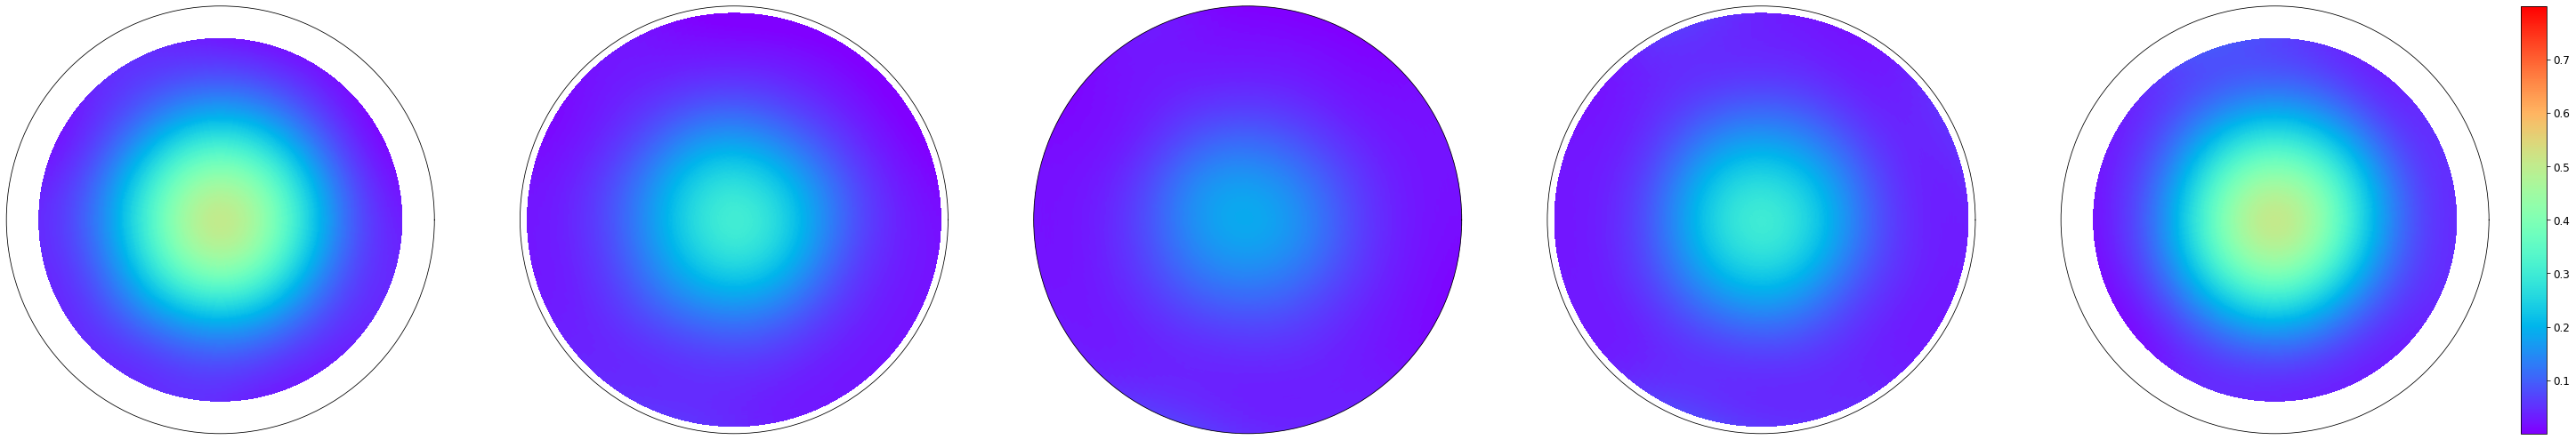

In [6]:
from matplotlib.colors import Normalize
vmin = 0
vmax = 0.8
norm = Normalize(vmin = vmin,vmax = vmax)


fig = plt.figure(figsize=(50, 10))


theta_sequence = np.linspace(0, 2*np.pi, sample_num)
#r_sequence = np.linspace(0, radius_z, sample_num)

radius_list = [np.sqrt(rcell**2 - i**2) for i in z_axis_list]


ax1 = plt.subplot(151, projection='polar')
y_pred_m = y_pred_list[0]
r_sequence = np.linspace(0, radius_list[0], sample_num)
ax1.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax1.set_rgrids([])
ax1.set_rmax(1.5)
ax1.set_thetagrids([])
ax1.grid(False) 
#ax1.set_title('z = 0.8 cm')
#plt.colorbar(pc, shrink=.8)
#plt.grid(c='black')

ax2 = plt.subplot(152, projection='polar')
y_pred_m = y_pred_list[1]
r_sequence = np.linspace(0, radius_list[1], sample_num)
ax2.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax2.set_rgrids([])
ax2.set_rmax(1.5)
ax2.set_thetagrids([])
#ax2.set_title('z = 0.4 cm')
#plt.colorbar(pc, shrink=.8)
#plt.grid(c='black')

ax3 = plt.subplot(153, projection='polar')
y_pred_m = y_pred_list[2]
r_sequence = np.linspace(0, radius_list[2], sample_num)
ax3.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax3.set_rgrids([])
ax3.set_rmax(1.5)
ax3.set_thetagrids([])
#ax3.set_title('z = 0 cm')
ax3.grid(False) 

ax4 = plt.subplot(154, projection='polar')
y_pred_m = y_pred_list[3]
r_sequence = np.linspace(0, radius_list[3], sample_num)
ax4.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax4.set_rgrids([])
ax4.set_rmax(1.5)
ax4.set_thetagrids([])
#ax4.set_title('z = -0.4 cm')

ax5 = plt.subplot(155, projection='polar')
y_pred_m = y_pred_list[4]
r_sequence = np.linspace(0, radius_list[4], sample_num)
fig5 = ax5.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax5.set_rgrids([])
ax5.set_rmax(1.5)
ax5.set_thetagrids([])
#ax5.set_title('z = -0.8 cm')

# 调整位置，色彩棒
cax = fig.add_axes([ax5.get_position().x1+0.01,ax5.get_position().y0,0.008,ax5.get_position().height])
cb = fig.colorbar(fig5, ax=[ax1, ax2, ax3, ax4, ax5], shrink=0.7, cax=cax)

cb.set_ticks([0.1*(i+1) for i in range(7)])
cb.ax.tick_params(labelsize=12)  #设置色标刻度字体大小。
#cb.set_label('Polarzaiton Rate', fontdict={'size':16}) ## 设置标签字体


# 设置图例字体大小


file_name = './result/test.png'
plt.savefig(file_name, dpi=320, bbox_inches='tight')
#plt.show()


C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


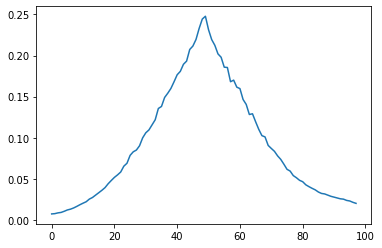

In [36]:
#x, y = X_data[:, 0], X_data[:, 1]
X = random_sphere_points(z= 0.4)
x = X[:, 0]
y_pred = model.predict(X)[:, 0]
## 放到区间下，
Pz = y_pred
num_space = 100
X_lim = np.linspace(-1.5, 1.5, num_space+1)
x_space = 3/num_space
Pz_dist = np.zeros(num_space) ## Pz value add
Pz_space_num = np.zeros(num_space) ## Pz number

for x_idx in range(len(x)):
      Pz_idx = int((x[x_idx]+1.5)/x_space-1)
      Pz_dist[Pz_idx] += Pz[x_idx]
      Pz_space_num[Pz_idx] += 1

Pz_density = Pz_dist/Pz_space_num  
plt.figure()
plt.plot(Pz_density)